# **Fine-tuning for Image Classification with 🤗 Transformers**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## ImageFolder

This notebook leverages the [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to easily run the notebook on a custom dataset (namely, [EuroSAT](https://github.com/phelber/EuroSAT) in this tutorial). You can either load a `Dataset` from local folders or from local/remote files, like zip or tar.

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with a Image Classification head, such as:
* [ViT](https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTForImageClassification)
* [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin#transformers.SwinForImageClassification)
* [ConvNeXT](https://huggingface.co/docs/transformers/master/en/model_doc/convnext#transformers.ConvNextForImageClassification)

- in short, any model supported by [AutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification).

## Data augmentation

This notebook leverages Kornia's [image augmentations](https://kornia.readthedocs.io/en/latest/augmentation.module.html) for applying data augmentation - note that we do provide alternative notebooks which leverage other libraries, including:

* [Torchvision](https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb)
* [Albumentations](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb)
* [imgaug](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_imgaug.ipynb). 

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/microsoft/swin-tiny-patch4-window7-224 checkpoint, but note that there are many, many more available on the [hub](https://huggingface.co/models?other=vision). We will also use the [datasets](https://huggingface.co/docs/datasets/installation) library to load an image dataset

In [1]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

Before we start, let's install the `kornia`, `datasets` and `transformers` libraries. We'll install `evaluate` to evaluate our model's accuracy during and after training, which requires `sklearn`. Since we'll be working with images, we'll also ensure that `Pillow` is installed.

In [2]:
!pip install -q kornia datasets transformers evaluate sklearn Pillow

     |████████████████████████████████| 565 kB 34.8 MB/s 
     |████████████████████████████████| 365 kB 71.0 MB/s 
     |████████████████████████████████| 4.7 MB 61.0 MB/s 
     |████████████████████████████████| 69 kB 8.6 MB/s 
     |████████████████████████████████| 120 kB 72.6 MB/s 
     |████████████████████████████████| 115 kB 54.8 MB/s 
     |████████████████████████████████| 212 kB 31.8 MB/s 
     |████████████████████████████████| 127 kB 51.6 MB/s 
     |████████████████████████████████| 6.6 MB 61.2 MB/s 


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In this case, the EuroSAT dataset is hosted remotely, so we provide the `data_files` argument. Alternatively, if you have local folders with images, you can load them using the `data_dir` argument.

In [3]:
from datasets import load_dataset

# load a custom dataset from local/remote files or folders using the ImageFolder feature

# option: local/remote files (supporting the following formats: tar, gzip, zip, xz, rar, zstd)
dataset = load_dataset("imagefolder", data_files="https://madm.dfki.de/files/sentinel/EuroSAT.zip")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-0537267e6f812d56/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

**Note:** You can also provide several splits:

```python
dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})
```

Or load a dataset from your local:

```python
dataset = load_dataset("imagefolder", data_dir="path_to_folder")
```

If you want to share your dataset publicly or collaborate with others privately, you can also push your dataset to the hub very easily (and reload afterwards using load_dataset)!

```python
dataset.push_to_hub("nielsr/eurosat")
# Or use private=True to create a private dataset
dataset.push_to_hub("nielsr/eurosat", private=True)
```

**Datasets Hub: **

At Hugging Face, we host a variety of NLP, vision, speech and multi-modal datasets. Simply head over to our Hub and search for datasets. If you find a dataset you would like to use, you can simply pass in the repository name to load the dataset from the [hub](https://huggingface.co/datasets). As an example, let's load the [CIFAR-10 dataset](https://huggingface.co/datasets/cifar10) from the hub.

```python
dataset = load_dataset("cifar10")
```

Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [4]:
import evaluate

metric = evaluate.load("accuracy")

The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

To access an actual element, you need to select a split first, then give an index:

In [6]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F7D6F9A4CD0>,
 'label': 6}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [7]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

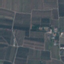

In [8]:
example['image']

Let's make it a little bigger as the images in the EuroSAT dataset are of low resolution (64x64 pixels):

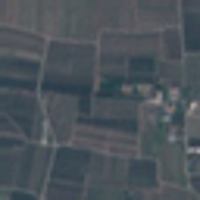

In [9]:
example['image'].resize((200, 200))

Let's print the corresponding label:

In [10]:
example['label']

6

As you can see, the `label` field is not an actual string label. By default the `ClassLabel` fields are encoded into integers for convenience:

In [11]:
dataset["train"].features["label"]

ClassLabel(num_classes=10, names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)

Let's create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [12]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'HerbaceousVegetation'

### Sharing your model

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [13]:
from huggingface_hub import notebook_login

notebook_login()


Then you need to install Git-LFS to upload your model checkpoints:

In [14]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

### Preprocessing the data

All Hugging Face model classes expect the input to be correctly preprocessed, so we need to preprocess these images before we can feed them to our model. Preprocessing images typically comes down to:

1. **Resizing** them a particular size
2. **Normalizing** the color channels (R,G,B) using a mean and standard deviation.

These are referred to as **image transformations**.

In addition, one typically performs what is called **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `Kornia` for the image transformations/data augmentation in this tutorial, but note that one can use any other package (like [torchvision](https://pytorch.org/vision/stable/transforms.html), [albumentations](https://albumentations.ai/), [imgaug](https://github.com/aleju/imgaug), etc.).

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a image processor with the `AutoImageProcessor.from_pretrained` method.

This image processor is a minimal preprocessor that can be used to prepare images for inference.

In [15]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_resize": true,
  "image_processor_type": "ViTImageProcessor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224,
  },
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using [`.map()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=map#datasets.Dataset.map) or [`.set_transform()`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing). 

In [16]:
import kornia as K
from torch import nn
import torch
from PIL import Image
import numpy as np

class PreProcess(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""
    def __init__(self) -> None:
        super().__init__()
 
    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Image) -> torch.Tensor:
        x_tmp: np.ndarray = np.array(x)  # HxWxC
        x_out: torch.Tensor = K.image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        return x_out.float() / 255.0

train_transforms = nn.Sequential(
    PreProcess(),
    K.augmentation.Resize(size=224, side="short"),
    K.augmentation.CenterCrop(size=224),
    K.augmentation.RandomHorizontalFlip(p=0.5),
    K.augmentation.ColorJiggle(),
    K.augmentation.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
)

val_transforms = nn.Sequential(
    PreProcess(),
    K.augmentation.Resize(size=224, side="short"),
    K.augmentation.CenterCrop(size=224),
    K.augmentation.Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
)

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image).squeeze() for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image).squeeze() for image in example_batch["image"]]
    return example_batch

Next, we can preprocess our dataset by applying these functions. We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [17]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [18]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [19]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F7C820D2B10>,
 'label': 0,
 'pixel_values': tensor([[[ 0.8447,  0.8447,  0.8447,  ...,  0.6682,  0.6537,  0.6392],
          [ 0.8495,  0.8495,  0.8495,  ...,  0.6745,  0.6641,  0.6537],
          [ 0.8544,  0.8544,  0.8544,  ...,  0.6808,  0.6745,  0.6682],
          ...,
          [-0.0205, -0.0177, -0.0150,  ...,  1.1044,  1.2001,  1.2958],
          [ 0.0182,  0.0196,  0.0210,  ...,  1.0744,  1.1536,  1.2329],
          [ 0.0569,  0.0569,  0.0569,  ...,  1.0443,  1.1072,  1.1700]],
 
         [[ 0.5903,  0.5903,  0.5903,  ...,  0.0400,  0.0351,  0.0301],
          [ 0.5903,  0.5889,  0.5875,  ...,  0.0357,  0.0280,  0.0202],
          [ 0.5903,  0.5875,  0.5847,  ...,  0.0314,  0.0209,  0.0103],
          ...,
          [-0.2317, -0.2367, -0.2416,  ...,  0.2561,  0.3722,  0.4883],
          [-0.1971, -0.2020, -0.2070,  ...,  0.2090,  0.3041,  0.3993],
          [-0.1625, -0.1674, -0.1724,  ...,  0.1618,  0

In [20]:
train_ds[0]['pixel_values'].shape

torch.Size([3, 224, 224])

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `AutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

NOTE: in case you're planning to fine-tune an already fine-tuned checkpoint, like [facebook/convnext-tiny-224](https://huggingface.co/facebook/convnext-tiny-224) (which has already been fine-tuned on ImageNet-1k), then you need to provide the additional argument `ignore_mismatched_sizes=True` to the `from_pretrained` method. This will make sure the output head (with 1000 output neurons) is thrown away and replaced by a new, randomly initialized classification head that includes a custom number of output neurons. You don't need to specify this argument in case the pre-trained model doesn't include a head. 

In [21]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

#### Trainer

The [Trainer class](https://huggingface.co/docs/transformers/main_classes/trainer) provides an API for feature-complete training in PyTorch for most standard use cases. To instantiate a `Trainer`, we will need to define the training configuration and the evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

In [22]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-eurosat-kornia",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument `push_to_hub` allows the Trainer to push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally with a name that is different from the name of the repository, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"nielsr/vit-finetuned-cifar10"` or `"huggingface/nielsr/vit-finetuned-cifar10"`).

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [23]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [24]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat-kornia into local empty directory.


You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 24300
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 570


Epoch,Training Loss,Validation Loss,Accuracy
1,0.085900,0.096875,0.968519
2,0.066400,0.062725,0.981481
3,0.035900,0.054041,0.982963


***** Running Evaluation *****
  Num examples = 2700
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/checkpoint-190
Configuration saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/checkpoint-190/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/checkpoint-190/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/checkpoint-190/preprocessor_config.json
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2700
  Batch size = 32
Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/checkpoint-380
Configuration saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/checkpoint-380/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/checkpoint-380/pytorch_model.bin
Feature ext

Upload file pytorch_model.bin:   0%|          | 3.34k/105M [00:00<?, ?B/s]

Upload file runs/Aug29_08-52-09_cc75a613d50e/events.out.tfevents.1661763148.cc75a613d50e.286.0:  23%|##3      …

To https://huggingface.co/nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat-kornia
   2d806d2..8e80863  main -> main

   2d806d2..8e80863  main -> main

To https://huggingface.co/nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat-kornia
   8e80863..93b8c0f  main -> main

   8e80863..93b8c0f  main -> main



***** train metrics *****
  epoch                    =          3.0
  total_flos               = 1687935228GF
  train_loss               =       0.1976
  train_runtime            =   0:29:42.28
  train_samples_per_second =       40.903
  train_steps_per_second   =         0.32


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 2700
  Batch size = 32


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =      0.983
  eval_loss               =      0.054
  eval_runtime            = 0:00:20.96
  eval_samples_per_second =    128.761
  eval_steps_per_second   =      4.054


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to swin-tiny-patch4-window7-224-finetuned-eurosat-kornia
Configuration saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/config.json
Model weights saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/pytorch_model.bin
Feature extractor saved in swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/preprocessor_config.json


Upload file runs/Aug29_08-52-09_cc75a613d50e/events.out.tfevents.1661765112.cc75a613d50e.286.2: 100%|#########…

To https://huggingface.co/nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat-kornia
   93b8c0f..1ee18f0  main -> main

   93b8c0f..1ee18f0  main -> main



'https://huggingface.co/nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/commit/1ee18f06019d72833eb5a81e08141f161ff121bd'

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForImageClassification, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("nielsr/my-awesome-model")
model = AutoModelForImageClassification.from_pretrained("nielsr/my-awesome-model")

```

## Inference

Let's say you have a new image, on which you'd like to make a prediction. Let's load a satellite image of a highway, and see how the model does.

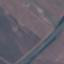

In [ ]:
from PIL import Image
import requests

url = "https://datasets-server.huggingface.co/assets/nielsr/eurosat-demo/--/nielsr--eurosat-demo/train/0/image/image.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

We'll load the image processor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "swin-tiny-patch4-window7-224-finetuned-eurosat-kornia"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

loading image processor configuration file swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/preprocessor_config.json
Feature extractor ViTImageProcessor {
  "do_normalize": true,
  "do_resize": true,
  "image_processor_type": "ViTImageProcessor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

loading configuration file swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/config.json
Model config SwinConfig {
  "_name_or_path": "swin-tiny-patch4-window7-224-finetuned-eurosat-kornia",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "AnnualCrop",
    "1": "Forest",
    "2": "HerbaceousVegetation",
    "3": "Highway",
    "4": "I

We'll apply the exact same transformations as we did for validation. This involves 1) rescaling 2) resizing the shorter edge 3) center cropping 4) normalizing.

In [ ]:
# prepare image for the model
pixel_values = val_transforms(image.convert("RGB"))
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Highway


Looks like our model got it correct! 

## Pipeline API

An alternative way to quickly perform inference with any model on the hub is by leveraging the [Pipeline API](https://huggingface.co/docs/transformers/main_classes/pipelines), which abstracts away all the steps we did manually above for us. It will perform the preprocessing, forward pass and postprocessing all in a single object. 

Let's showcase this for our trained model:

In [ ]:
from transformers import pipeline

pipe = pipeline("image-classification", "nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat-kornia")

loading configuration file https://huggingface.co/nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat-kornia/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/b3eaaac5181ffa5c5bf07a7166dc39e66d48c9d6b8fc1ed94c5d31caa6fca218.8b60c7d323a7d1dee3b68511fce0682465c32224e710bda6b83ab1d60e17ea24
Model config SwinConfig {
  "_name_or_path": "nielsr/swin-tiny-patch4-window7-224-finetuned-eurosat-kornia",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    6,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 96,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "AnnualCrop",
    "1": "Forest",
    "2": "HerbaceousVegetation",
    "3": "Highway",
    "4": "Industrial",
    "5": "Pasture",
    "6": "PermanentCrop",
    "7": "Residential",
    "8": "River",
    "9": "SeaLake"
  },
  "image_size": 224,
  "initializer_ran

In [ ]:
pipe(image)

[{'score': 0.9998598098754883, 'label': 'Highway'},
 {'score': 0.00011431645543780178, 'label': 'River'},
 {'score': 5.5520140449516475e-06, 'label': 'AnnualCrop'},
 {'score': 4.760188403452048e-06, 'label': 'HerbaceousVegetation'},
 {'score': 4.518807600106811e-06, 'label': 'Residential'}]

As we can see, it does not only show the class label with the highest probability, but does return the top 5 labels, with their corresponding scores. Note that the pipelines also work with local models and image processors:

In [ ]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

In [ ]:
pipe(image)

[{'score': 0.9998598098754883, 'label': 'Highway'},
 {'score': 0.00011431645543780178, 'label': 'River'},
 {'score': 5.5520140449516475e-06, 'label': 'AnnualCrop'},
 {'score': 4.760188403452048e-06, 'label': 'HerbaceousVegetation'},
 {'score': 4.518807600106811e-06, 'label': 'Residential'}]